In [2]:
# !pip install gensim spacy transformers chromadb sentence-transformers -q
# !python -m spacy download en_core_web_md -q


# ## In Colab: Restart session to avoid issues, specially with gensim

In [46]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import gensim
from gensim.models import Word2Vec

import spacy

from transformers import AutoTokenizer, AutoModel
import torch

import nltk
# Download NLTK data quietly
nltk.download('punkt', quiet=True)  # Punkt tokenizer for sentence splitting
nltk.download('brown', quiet=True)  # Brown corpus for training data
from nltk.corpus import brown # for Word2Vec training with gensim





##Word-Document and Word-Word Matrices

In [4]:
# Example documents (Shakespeare plays)
documents = {
    "As You Like It": "battle good fool wit love forest magic",
    "Twelfth Night": "good fool wit love comedy mistaken identity",
    "Julius Caesar": "battle battle battle good fool war rome politics",
    "Henry V": "battle battle battle battle good wit war king england"
}

In [5]:
def create_term_document_matrix(documents):
  """ Creates term-document matrix
  Rows represent words (terms)
  Columns represent docs
  Cells have the frequencies (counts)"""

  all_the_words = set()

  for doc in documents.values():
    all_the_words.update(doc.split())

  vocab = sorted(all_the_words)
  print(vocab)

  matrix = []

  for word in vocab:
    row = []

    for doc_name, doc_text in documents.items():
      count = doc_text.split().count(word)
      row.append(count)

    matrix.append(row)

  print(matrix)


  df = pd.DataFrame(matrix,
                    index=vocab,
                    columns=list(documents.keys()))

  return df

term_doc_matrix = create_term_document_matrix(documents)
print("\n", term_doc_matrix)

['battle', 'comedy', 'england', 'fool', 'forest', 'good', 'identity', 'king', 'love', 'magic', 'mistaken', 'politics', 'rome', 'war', 'wit']
[[1, 0, 3, 4], [0, 1, 0, 0], [0, 0, 0, 1], [1, 1, 1, 0], [1, 0, 0, 0], [1, 1, 1, 1], [0, 1, 0, 0], [0, 0, 0, 1], [1, 1, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 1], [1, 1, 0, 1]]

           As You Like It  Twelfth Night  Julius Caesar  Henry V
battle                 1              0              3        4
comedy                 0              1              0        0
england                0              0              0        1
fool                   1              1              1        0
forest                 1              0              0        0
good                   1              1              1        1
identity               0              1              0        0
king                   0              0              0        1
love                   1              1              0        0
magic 

## TF-IDF


In [6]:
def compute_tf_idf(term_doc_matrix):
  """Compute Term Frequency × Inverse Document Frequency"""

  matrix = term_doc_matrix.values # Convert to numpy.ndarray to apply np.where easily

  n_docs = matrix.shape[1]

  print(np.where(matrix>0, 1,0))

  # Term freq
  tf = np.where(matrix > 0, 1 + np.log10(matrix + 1e-10), 0) # Raw counts can be misleading (100 occurrences isn't 100x more important than 1), for taht reason we compress it with the log10. Also, added small epsilon to avoid log(0) and warning
  print("\nTerm Freq:\n", tf, "\n")

  # Doc freq (words appearing on how many docs)
  df = np.sum(matrix>0, axis=1)
  print("\nDoc Freq:\n", df, "\n")

  # Inverse doc freq
  idf = np.log10(n_docs/df)
  print("\nInverse Doc Freq without log(10):\n", n_docs/df, "\n")

  print("\nInverse Doc Freq (with log(10)):\n", idf, "\n")


  # TF-IDF
  idf = idf[:, np.newaxis] # Flatten idf
  print("\nBroadcasted Inverse Doc Freq to dimensionality (n,1):\n", idf, "\n")

  tf_idf = tf*idf
  print("\nTF-IDF:\n", idf, "\n")

  return pd.DataFrame(tf_idf, index=term_doc_matrix.index, columns=term_doc_matrix.columns)

tf_idf_matrix = compute_tf_idf(term_doc_matrix)
tf_idf_matrix

[[1 0 1 1]
 [0 1 0 0]
 [0 0 0 1]
 [1 1 1 0]
 [1 0 0 0]
 [1 1 1 1]
 [0 1 0 0]
 [0 0 0 1]
 [1 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 1]
 [1 1 0 1]]

Term Freq:
 [[1.         0.         1.47712125 1.60205999]
 [0.         1.         0.         0.        ]
 [0.         0.         0.         1.        ]
 [1.         1.         1.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         1.         1.         1.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.         1.        ]
 [1.         1.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         1.        ]
 [1.         1.         0.         1.        ]] 


Doc Freq:
 [3 1 1 3 1 4 1 1 2 1 1 1 1 2 3] 


Inverse Doc Freq without log(10):
 [1.33333333 4.         4.      

,As You Like It,Twelfth Night,Julius Caesar,Henry V
battle,0.124939,0.000000,0.184550,0.200159
comedy,0.000000,0.602060,0.000000,0.000000
england,0.000000,0.000000,0.000000,0.602060
fool,0.124939,0.124939,0.124939,0.000000
forest,0.602060,0.000000,0.000000,0.000000
good,0.000000,0.000000,0.000000,0.000000
identity,0.000000,0.602060,0.000000,0.000000
king,0.000000,0.000000,0.000000,0.602060
love,0.301030,0.301030,0.000000,0.000000
magic,0.602060,0.000000,0.000000,0.000000


## Word-Word Co-occurrence (Association)


In [7]:
def create_word_cooccurrence_matrix(documents, window_size=2):
  cooccurrence = defaultdict(lambda: defaultdict(int))

  for doc in documents.values():
    words = doc.split()

    for i, target_word in enumerate(words):# print(i,target_word)

      start = max(0, i - window_size) # Sets the start of the context window so it is not below 0
      end = min(len(words), i + window_size + 1) # Sets the end of the context window so it is not above the last word
      print("Word ", target_word, "has a window with indexes range ", start, "-", end, "\n")

      for j in range(start,end):
        if i != j:                  # Not counting the word with itself

          context_word = words[j]
          cooccurrence[target_word][context_word] += 1

      print("cooccurrence: ", cooccurrence)


  # all_words = []
  # for doc in documents.values():
  #   for word in doc.split(): all_words.append(word)
  # sorted(set(all_words))

  all_words = sorted(set(word for doc in documents.values() for word in doc.split(" ")  )) # Same as above but in a set comprehension
  print("\nall_words: ", all_words)

  matrix = []
  for target_word in all_words:
    row = []
    for ctxt_word in all_words:
      row.append(cooccurrence[target_word][ctxt_word])
    matrix.append(row)

  return pd.DataFrame(matrix, index = all_words, columns = all_words)

cooc_matrix = create_word_cooccurrence_matrix(documents, window_size=2)
cooc_matrix

Word  battle has a window with indexes range  0 - 3 

cooccurrence:  defaultdict(<function create_word_cooccurrence_matrix.<locals>.<lambda> at 0x7f2ce829fba0>, {'battle': defaultdict(<class 'int'>, {'good': 1, 'fool': 1})})
Word  good has a window with indexes range  0 - 4 

cooccurrence:  defaultdict(<function create_word_cooccurrence_matrix.<locals>.<lambda> at 0x7f2ce829fba0>, {'battle': defaultdict(<class 'int'>, {'good': 1, 'fool': 1}), 'good': defaultdict(<class 'int'>, {'battle': 1, 'fool': 1, 'wit': 1})})
Word  fool has a window with indexes range  0 - 5 

cooccurrence:  defaultdict(<function create_word_cooccurrence_matrix.<locals>.<lambda> at 0x7f2ce829fba0>, {'battle': defaultdict(<class 'int'>, {'good': 1, 'fool': 1}), 'good': defaultdict(<class 'int'>, {'battle': 1, 'fool': 1, 'wit': 1}), 'fool': defaultdict(<class 'int'>, {'battle': 1, 'good': 1, 'wit': 1, 'love': 1})})
Word  wit has a window with indexes range  1 - 6 

cooccurrence:  defaultdict(<function create_word_co

,battle,comedy,england,fool,forest,good,identity,king,love,magic,mistaken,politics,rome,war,wit
battle,16,0,0,2,0,5,0,0,0,0,0,0,0,0,1
comedy,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1
england,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
fool,2,0,0,0,0,3,0,0,2,0,0,0,1,1,2
forest,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
good,5,0,0,3,0,0,0,0,0,0,0,0,0,2,3
identity,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
king,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
love,0,1,0,2,1,0,0,0,0,1,1,0,0,0,2
magic,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


## PPMI (Positive Pointwise Mutual Information)

In [8]:
def compute_ppmi(cooc_matrix, alpha = 0.75):
  """
  Compute PPMI matrix from the Co-occurrence matrix.
  alpha = 0.75: Levy et al. (2015) found that a setting of α = 0.75 improved performance of embeddings on a wide range of tasks
  0.75 increases the probability assigned to rare contexts, and hence lowers their PMI (Pα(c) > P(c) when c is rare).
  """

  matrix = cooc_matrix.values.astype(float)

  total = np.sum(matrix)


  # Joint probabilities P(w,c)
  # Element-wise division by scalar
  p_wc = matrix / total
  print("\n p_wc: \n", p_wc, "\n")

  # Getting marginal probabilities
  p_w = np.sum(matrix, axis=1) / total
  p_c = np.sum(matrix, axis=0) / total # Although it is the same bcs it is a symmetric co-occurrence matrix


  # Smoothing and re-normalizing
  p_c_alpha = np.power(p_c, alpha)
  p_c_alpha = p_c_alpha / np.sum(p_c_alpha)

  for i,j,k in zip(cooc_matrix.index, p_w, p_c_alpha):print(i,j,round(k,4)) ## p_w = p_c because it is a symmetric matrix, with the power to alpha that changes


  # Calculate PMI
  epsilon = 1e-10 #Added small epsilon to avoid division by zero and log(0)

  pmi = np.log2((p_wc + epsilon)/
              (p_w[:,np.newaxis] * p_c_alpha[np.newaxis,:]+epsilon)) # Broadcasting p_w to dimension (1,n)
  print("\n PMI: \n", pmi, "\n")

  # Convert to PPMI (turn negatives to zero)
  ppmi = np.maximum(0,pmi)
  return pd.DataFrame(ppmi, index=cooc_matrix.index, columns=cooc_matrix.columns)



ppmi_matrix = compute_ppmi(cooc_matrix, alpha = 0.75)
ppmi_matrix


 p_wc: 
 [[0.16 0.   0.   0.02 0.   0.05 0.   0.   0.   0.   0.   0.   0.   0.
  0.01]
 [0.   0.   0.   0.   0.   0.   0.01 0.   0.01 0.   0.01 0.   0.   0.
  0.01]
 [0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.01
  0.  ]
 [0.02 0.   0.   0.   0.   0.03 0.   0.   0.02 0.   0.   0.   0.01 0.01
  0.02]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.   0.   0.   0.
  0.01]
 [0.05 0.   0.   0.03 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02
  0.03]
 [0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.
  0.  ]
 [0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01
  0.01]
 [0.   0.01 0.   0.02 0.01 0.   0.   0.   0.   0.01 0.01 0.   0.   0.
  0.02]
 [0.   0.   0.   0.   0.01 0.   0.   0.   0.01 0.   0.   0.   0.   0.
  0.  ]
 [0.   0.01 0.   0.   0.   0.   0.01 0.   0.01 0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01
  0.  ]
 [0.   0.   0.   0.01 0.   0.   0.   0.   0.

,battle,comedy,england,fool,forest,good,identity,king,love,magic,mistaken,politics,rome,war,wit
battle,1.843331,0.000000,0.000000,0.000000,0.000000,0.828652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
comedy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.117016,0.000000,1.617016,0.000000,2.678294,0.000000,0.000000,0.000000,1.178294
england,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.678294,0.000000,0.000000,0.000000,0.000000,0.000000,2.617016,0.000000
fool,0.000000,0.000000,0.000000,0.000000,0.000000,1.217217,0.000000,0.000000,1.157584,0.000000,0.000000,0.000000,1.218862,0.157584,0.718862
forest,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.032053,3.532053,0.000000,0.000000,0.000000,0.000000,1.593331
good,1.049782,0.000000,0.000000,1.156965,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.916576,1.062817
identity,0.000000,3.367016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.678294,0.000000,0.000000,0.000000,0.000000
king,0.000000,0.000000,3.532053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.032053,1.593331
love,0.000000,1.367016,0.000000,1.272442,1.678294,0.000000,0.000000,0.000000,0.000000,2.117016,1.678294,0.000000,0.000000,0.000000,1.178294
magic,0.000000,0.000000,0.000000,0.000000,3.678294,0.000000,0.000000,0.000000,2.617016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Cosine Similarity

In [9]:
def cosine_similarity(vec1, vec2):
  """
  Compute cosine similarity between two vectors
  Dot product divide by the product of the Norms of both to normalize them
  cosine(v1, v2) = (v1 . v2) / (|v1| x |v1|)
  """

  dot_prod = np.dot(vec1, vec2)

  magnitude1 = np.sqrt(np.sum(vec1**2))
  magnitude2 = np.sqrt(np.sum(vec2**2))

  # Prevent div by zero
  if magnitude1 == 0 or magnitude2 == 0: return 0

  return np.dot(vec1,vec2)/ (magnitude1 * magnitude2)



### Usecase for Cosine Similarity

In [10]:
def find_similar_words(word,matrix,top_n=3):
  """Finds the most similar words to a target word."""

  if word not in matrix.index:
    return([])

  target_vector = matrix.loc[word].values # Convert to pandas series
  similarities = []

  for other_word in matrix.index:
    if other_word != word:
      other_vector = matrix.loc[other_word].values
      sim = cosine_similarity(target_vector,other_vector)
      similarities.append((other_word, sim))

  similarities.sort(key=lambda x:x[1], reverse=True)  # Sort by similarity in descending order

  return similarities[:top_n]

find_similar_words('battle', tf_idf_matrix, 3)

[('war', 0.9081207804878239),
 ('england', 0.6681933257466228),
 ('king', 0.6681933257466228)]

##Simple Word2Vec Implementation (Skip-gram concept)

In [11]:
def sigmoid(x):
    """Sigmoid activation function: σ(x) = 1 / (1 + e^(-x))"""
    return 1 / (1 + np.exp(-x))

In [12]:
class SkipGram:
  """Simplified Skipgram"""

  def __init__(self, vocab_size, embedding_dim=10):
    # Random initialization multiplied by small value
    self.W = np.random.randn(vocab_size, embedding_dim) * 0.1
    self.C = np.random.randn(vocab_size, embedding_dim) * 0.1
    self.vocab_size = vocab_size

  def forward(self, target_idx, context_idx):
    "Conpute P(context_word|target_word)"

    # Get embeddings by indexing into matrices
    target_embedding = self.W[target_idx]
    context_embedding = self.W[context_idx]

    # Dot product and sigmoid
    dot_product = np.dot(target_embedding, context_embedding)
    probability = sigmoid(dot_product)

    return probability

  def train_pair(self, target_idx, context_idx, label, learning_rate=0.01):
    """
    Train on a single target-context pair.
    label: 1 for positive (real context), 0 for negative (noise)
    """

    # Forward pass
    prob = self.forward(target_idx, context_idx)

    gradient  = (prob-label) # derivative of loss w.r.t. activation

    # Update embeddings with gradient descent
    self.W[target_idx] -= learning_rate * gradient * self.C[context_idx]
    self.C[target_idx] -= learning_rate * gradient * self.W[target_idx]

    print("")
    print(self.W[target_idx], self.C[target_idx] )
    print("")


### Usecase of SkipGram

In [13]:
vocab = ['battle', 'good', 'fool', 'wit', 'love']

vocab_to_idx = {word: idx for idx,word in enumerate(vocab)}
print(vocab_to_idx)

model = SkipGram(len(vocab), embedding_dim=5)

print("\nTraining Skip-gram:")
print("Initial embedding for 'battle':", model.W[vocab_to_idx['battle']].round(3))


for _ in range(20):
  model.train_pair(vocab_to_idx['battle'], vocab_to_idx['good'], 1) # Positive example: 'battle' appears with 'good'
  model.train_pair(vocab_to_idx['battle'], vocab_to_idx['love'], 0) # Negative example: 'battle' doesn't appear with 'love'

print("Updated embedding for 'battle':", model.W[vocab_to_idx['battle']].round(3))


{'battle': 0, 'good': 1, 'fool': 2, 'wit': 3, 'love': 4}

Training Skip-gram:
Initial embedding for 'battle': [ 0.051  0.014 -0.137 -0.119 -0.133]

[ 0.05103227  0.0145106  -0.13710094 -0.11761859 -0.13316623] [ 0.02259421  0.0129427   0.07595019 -0.01104619  0.02594421]


[ 0.05081601  0.01444493 -0.13774327 -0.11723552 -0.13359638] [ 0.02233563  0.0128692   0.07665108 -0.01044965  0.02662401]


[ 0.05110116  0.01470047 -0.13742465 -0.11593757 -0.13341427] [ 0.02258791  0.01294177  0.07597263 -0.01102202  0.02596535]


[ 0.0508849   0.0146348  -0.13806696 -0.1155545  -0.13384441] [ 0.02232899  0.0128673   0.07667516 -0.01043404  0.0266464 ]


[ 0.05117009  0.01489037 -0.1377483  -0.11425638 -0.13366228] [ 0.02258165  0.01294083  0.07599502 -0.01099819  0.02598643]


[ 0.05095384  0.0148247  -0.1383906  -0.11387333 -0.13409242] [ 0.02232239  0.0128654   0.07669918 -0.01041878  0.02666872]


[ 0.05123907  0.01508031 -0.1380719  -0.11257504 -0.13391026] [ 0.02257541  0.01293987  0.076017

###  Visualization of Embeddings with t-SNE

Visualizing word embeddings from PPMI matrix
[[ 27.061226    19.571266  ]
 [ 41.878567   -13.310328  ]
 [ 42.025864    10.631084  ]
 [  5.84458      8.318714  ]
 [ 50.117714    -0.27983123]
 [ 29.434593     6.7900376 ]
 [ 29.489666   -19.734055  ]
 [ 13.671186    21.93513   ]
 [ 37.44587     -1.3878596 ]
 [ 17.967104    -1.2565985 ]
 [ 27.606993    -7.166381  ]
 [  6.0496125   -5.7165866 ]
 [ 18.413963    10.150228  ]
 [ 39.11019     22.808086  ]
 [ 16.349966   -15.06282   ]]


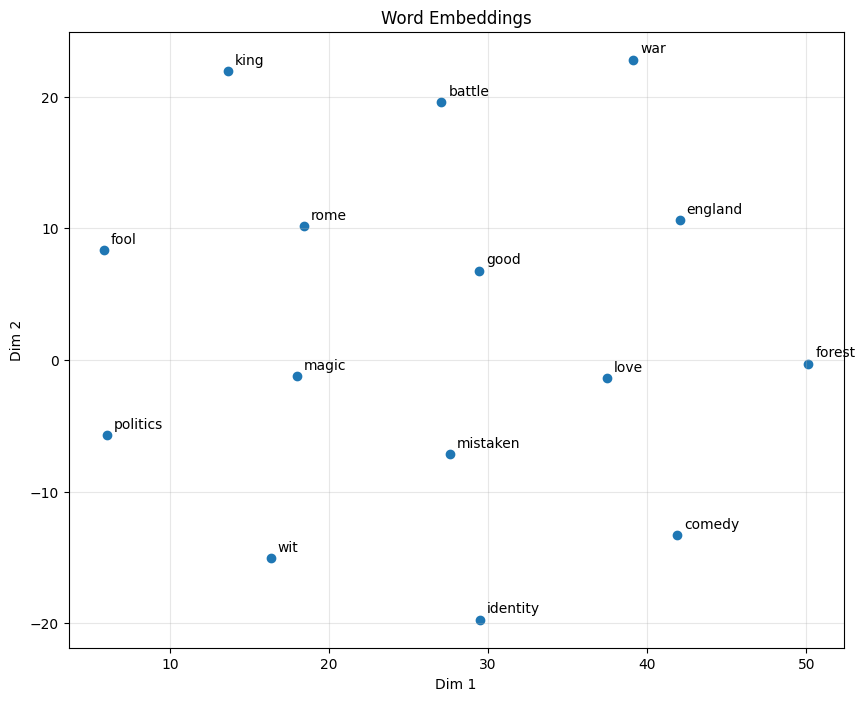

In [14]:
def visualize_embeddings(embeddings, labels):
  """Visualize high-dimensional embedding in two dimensions with t-Distributed Stochastic Neighbor Embedding"""

  # Reducing dimensionality to 2 with t-SNE
  if embeddings.shape[1] > 2 and embeddings.shape[0] > 5: # Checking that there are enough samples
    # Adjust perplexity based on number of samples
    ppl = min(30,embeddings.shape[0]-1) # 30 is the default, but must be < n_samples
    tsne = TSNE(n_components = 2, random_state=42, perplexity=ppl)
    embeddings_2d = tsne.fit_transform(embeddings)
  else:
    embeddings_2d = embeddings[:,:2] # Takes just 2 first dimensions

  print(embeddings_2d)

  plt.figure(figsize=(10,8))
  plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])

  # Adding labels
  for i,label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), xytext=(5, 5), textcoords='offset points')

  plt.title("Word Embeddings")
  plt.xlabel("Dim 1")
  plt.ylabel("Dim 2")
  plt.grid(True, alpha=.3)
  plt.show()

if ppmi_matrix.shape[0]>0:
  print("Visualizing word embeddings from PPMI matrix")
  embeddings = ppmi_matrix.values
  labels = ppmi_matrix.index.tolist()
  visualize_embeddings(embeddings, labels)

### Word2Vec (with Gensim lib instead, common approach)


In [15]:
# Using brown corpus
sentences = brown.sents()#[:10000]
print(sentences[:1000])

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ...]


In [16]:
# Training Word2Vec
model = Word2Vec(
    sentences = sentences,
    vector_size = 100, # Embedding dimensionality
    window = 5,
    min_count = 5, # Ignoring words with frequency < 5
    workers = 4, # Parallel threads
    sg = 1, # Skip-gram (1) or Continuous Bag-of-Words (0)
    negative = 5, # Negative samples per each positive
    epochs = 10 # iters over the whole corpus
)

In [17]:
print("\nMost similar words to 'man':")
similar_words = model.wv.most_similar('man', topn=5)
for word, similarity in similar_words:
    print(f"  {word}: {similarity:.3f}")
### Interesting results

print("\nMost similar words to 'Christ':")
similar_words = model.wv.most_similar('Christ', topn=5)
for word, similarity in similar_words:
    print(f"  {word}: {similarity:.3f}")




Most similar words to 'man':
  woman: 0.632
  boy: 0.622
  citizen: 0.599
  monk: 0.599
  guy: 0.598

Most similar words to 'Christ':
  Jesus: 0.825
  eternal: 0.804
  God: 0.800
  Son: 0.791
  Saviour: 0.762


In [18]:
# Word analogies
print("\nWord analogy: father - man + woman = ?")
# positive: words to add, negative: words to subtract
result = model.wv.most_similar(positive=['father', 'woman'], negative=['man'], topn=1)
print(f"  Result: {result[0][0]} (similarity: {result[0][1]:.3f})")
# Probably needs more data in the corpus



Word analogy: father - man + woman = ?
  Result: mother (similarity: 0.720)


In [19]:
# Word analogies
print("\nWord analogy: queen - woman + man = ?")
# positive: words to add, negative: words to subtract
result = model.wv.most_similar(positive=['queen', 'man'], negative=['woman'], topn=1)
print(f"  Result: {result[0][0]} (similarity: {result[0][1]:.3f})")



Word analogy: queen - woman + man = ?
  Result: presiding (similarity: 0.655)


### Visualization in 2D with PCA

word_vectors shpae: (26, 100)
word_vectors[:5,:5]: 
 [[ 0.04189809 -0.19704002  0.15089552  0.11237249  0.14436695]
 [ 0.2228708   0.11076368  0.49441546  0.29954737  0.03207644]
 [-0.00621594  0.04499584  0.07347209 -0.13069215  0.08310986]
 [-0.36987075  0.1555789   0.13787106  0.09389531  0.22582097]
 [ 0.28475466  0.05514208  0.23694187 -0.06801151  0.0141738 ]]
word_labels: 
 ['brave', 'fear', 'devil', 'hero', 'monster', 'doctor', 'faith', 'eternal', 'health', 'king', 'queen', 'man', 'woman', 'princess', 'boy', 'girl', 'father', 'mother', 'god', 'power', 'money', 'glory', 'God', 'Son', 'Jesus', 'Christ']
vectors_2d with PCA:
 [[ 3.4723446e-01 -5.5621654e-01]
 [-6.2840217e-01 -3.8991493e-01]
 [ 6.0459793e-02 -3.2063973e-01]
 [-1.7839107e-01  3.6523989e-01]
 [ 2.9235309e-01 -8.4042764e-01]
 [ 1.2630624e+00 -2.2122906e-01]
 [-1.0984217e+00 -3.4366462e-02]
 [-1.0092980e+00  1.3243965e-03]
 [ 4.0589109e-02 -1.6540844e+00]
 [-8.1661254e-02 -5.2211982e-01]
 [ 7.6459473e-01 -1.1590302e-01

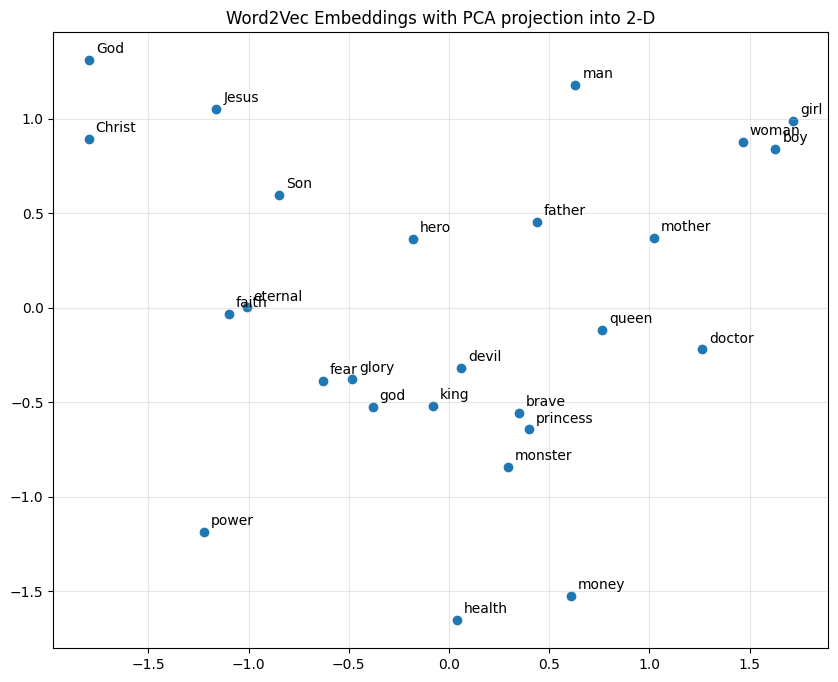

In [20]:
def plot_word_vectors(model, words):
  """Plot word vectors in 2-D with Princpal Component Analysis"""

  word_vectors = np.array([model.wv[word] for word in words if word in model.wv])
  word_labels = [word for word in words if word in model.wv]

  print("word_vectors shpae:", word_vectors.shape)
  print("word_vectors[:5,:5]: \n", str(word_vectors[:5,:5]))
  print("word_labels: \n", word_labels)


  # Reducing dimensionality to just 2-D with PCA
  pca = PCA(n_components = 2)
  vectors_2d = pca.fit_transform(word_vectors)

  print("vectors_2d with PCA:\n", vectors_2d)

  # Plot
  plt.figure(figsize=(10,8))
  plt.scatter(vectors_2d[:,0], vectors_2d[:,1])
  plt.title("Word2Vec Embeddings with PCA projection into 2-D")
  plt.grid(True, alpha =.3)

  for i, word in enumerate(word_labels):
    plt.annotate(word, xy=(vectors_2d[i,0], vectors_2d[i,1]), xytext=(5, 5), textcoords='offset points')

  plt.show()

words_to_plot = ['brave', 'fear', 'devil', 'hero' ,'monster','doctor','faith', 'eternal', 'health','king', 'queen', 'man', 'woman', 'prince', 'princess', 'boy', 'girl', 'father', 'mother', 'god', 'noise_asdfasdf', 'power', 'money',  'glory', 'God', 'Son', 'Jesus', 'Christ']
plot_word_vectors(model, words_to_plot)


## TF-IDF with Scikit-learn

In [21]:
# Sample documents
documents = [
    "The quick brown fox jumps over the lazy dog",
    "A quick brown dog outpaces a quick fox",
    "The lazy cat sleeps all day long",
    "Machine learning is fascinating and powerful",
    "Deep learning revolutionized natural language processing",
    "Natural language processing helps computers understand human language"
]

In [22]:
# TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features = 100, # Max vocab size
    ngram_range = (1,2), # Use unigrams and bigrams (1-word and 2-word phrases)
    stop_words = 'english', # Removing English stopwords
    lowercase = True, # Converts to lowercase
    use_idf = True,   # IDF weighting
    smooth_idf = True, # Add-1 (Laplace) Smoothing
    sublinear_tf = True # Uses log(tf) instead of just tf
)

# vectorizer

# Fit and trasnform docs
tfidf_matrix = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

print("tfidf_matrix[1]\n")
for i in tfidf_matrix[1]: print(i)

print("feature_names:\n ",feature_names)

tfidf_df = pd.DataFrame(
  tfidf_matrix.toarray(),
  columns=feature_names,
  index=[f"Doc{i}" for i in range(len(documents))]
)

print("\ntfidf_df.iloc[1][:20]\n")
print(tfidf_df.iloc[1][:20])

print("TF-IDF Matrix shape:", tfidf_matrix.shape)
print("\nTop terms by TF-IDF score in first document:")
doc_tfidf = tfidf_df.iloc[0]  # First doc
top_terms = doc_tfidf.nlargest(5)  # Get 5 largest values
for term, score in top_terms.items():
  print(f"  {term}: {score:.3f}")




tfidf_matrix[1]

  (0, 41)	0.4477010965312605
  (0, 0)	0.264419479695321
  (0, 15)	0.264419479695321
  (0, 11)	0.264419479695321
  (0, 42)	0.264419479695321
  (0, 36)	0.3224571547338746
  (0, 1)	0.3224571547338746
  (0, 12)	0.3224571547338746
  (0, 37)	0.3224571547338746
  (0, 43)	0.3224571547338746
feature_names:
  ['brown' 'brown dog' 'brown fox' 'cat' 'cat sleeps' 'computers'
 'computers understand' 'day' 'day long' 'deep' 'deep learning' 'dog'
 'dog outpaces' 'fascinating' 'fascinating powerful' 'fox' 'fox jumps'
 'helps' 'helps computers' 'human' 'human language' 'jumps' 'jumps lazy'
 'language' 'language processing' 'lazy' 'lazy cat' 'lazy dog' 'learning'
 'learning fascinating' 'learning revolutionized' 'long' 'machine'
 'machine learning' 'natural' 'natural language' 'outpaces'
 'outpaces quick' 'powerful' 'processing' 'processing helps' 'quick'
 'quick brown' 'quick fox' 'revolutionized' 'revolutionized natural'
 'sleeps' 'sleeps day' 'understand' 'understand human']

tfidf_df

### Document similarity on the tfidf_matrix


In [26]:
from sklearn.metrics.pairwise import cosine_similarity # Cosine similarity from the lib

print("\nDocument similarity matrix:")
similarity_matrix = cosine_similarity(tfidf_matrix)
similarity_df = pd.DataFrame(
  similarity_matrix,
  index=[f"Doc{i}" for i in range(len(documents))],
  columns=[f"Doc{i}" for i in range(len(documents))]
)
print(similarity_df.round(3))

def find_similar_documents(doc_id, similarity_matrix, documents, top_n=2):
  """Find documents most similar to a given document."""
  similarities = similarity_matrix[doc_id]
  print("\nsimilarities:\n", similarities, "\n")

  similar_indices = np.argsort(similarities)[::-1][1:top_n+1] # argsort() returns indices that would sort array
  print("\nnp.argsort(similarities):", np.argsort(similarities), "\n")

  print(f"\nDocuments similar to: '{documents[doc_id]}'")
  for idx in similar_indices:
      print(f"  Similarity {similarities[idx]:.3f}: '{documents[idx]}'")


find_similar_documents(4, similarity_matrix, documents)


Document similarity matrix:
       Doc0   Doc1   Doc2   Doc3   Doc4   Doc5
Doc0  1.000  0.411  0.076  0.000  0.000  0.000
Doc1  0.411  1.000  0.000  0.000  0.000  0.000
Doc2  0.076  0.000  1.000  0.000  0.000  0.000
Doc3  0.000  0.000  0.000  1.000  0.087  0.000
Doc4  0.000  0.000  0.000  0.087  1.000  0.345
Doc5  0.000  0.000  0.000  0.000  0.345  1.000

similarities:
 [0.         0.         0.         0.08660601 1.         0.34514035] 


np.argsort(similarities): [0 1 2 3 5 4] 


Documents similar to: 'Deep learning revolutionized natural language processing'
  Similarity 0.345: 'Natural language processing helps computers understand human language'
  Similarity 0.087: 'Machine learning is fascinating and powerful'


# Embeddings with SpaCy (a bit more modern)

### Written in Cython, spaCy is optimized for performance, enabling fast processing of large volumes of text data.

In [45]:
## !python -m spacy download en_core_web_md -q


# Load the model
nlp = spacy.load("en_core_web_md")
print(dir(nlp))

# Process text and get word vectors
text = "The quick brown fox jumps over the lazy dog"

doc = nlp(text)
print(doc)

print("spaCy Word Vectors:")
print(f"Vector dimension: {doc[0].vector.shape[0]}")  # First token's vector dimension


# Word similarity using spaCy
# Process individual words
word1 = nlp("king")
word2 = nlp("queen")
word3 = nlp("car")

print(f"\nWord similarities:")
# .similarity() method computes cosine similarity
print(f"  king - queen: {word1.similarity(word2):.3f}")
print(f"  king - car: {word1.similarity(word3):.3f}")

['Defaults', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_components', '_config', '_disabled', '_ensure_doc', '_ensure_doc_with_context', '_factory_meta', '_get_pipe_index', '_has_gpu_model', '_link_components', '_meta', '_multiprocessing_pipe', '_optimizer', '_path', '_pipe_configs', '_pipe_meta', '_resolve_component_status', 'add_pipe', 'analyze_pipes', 'batch_size', 'begin_training', 'component', 'component_names', 'components', 'config', 'create_optimizer', 'create_pipe', 'create_pipe_from_source', 'default_config', 'default_error_handler', 'disable_pipe', 'disable_pipes', 'disabled', 'enable_pipe', 'evaluate', 'factories', 'factory', 'fact

## Contextual Embeddings with Transformers (more modern)